In [1]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"


import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Laad de originele datasets
monthly_df = pd.read_csv("data.csv")
global_df = pd.read_csv("global-data-on-sustainable-energy.csv")


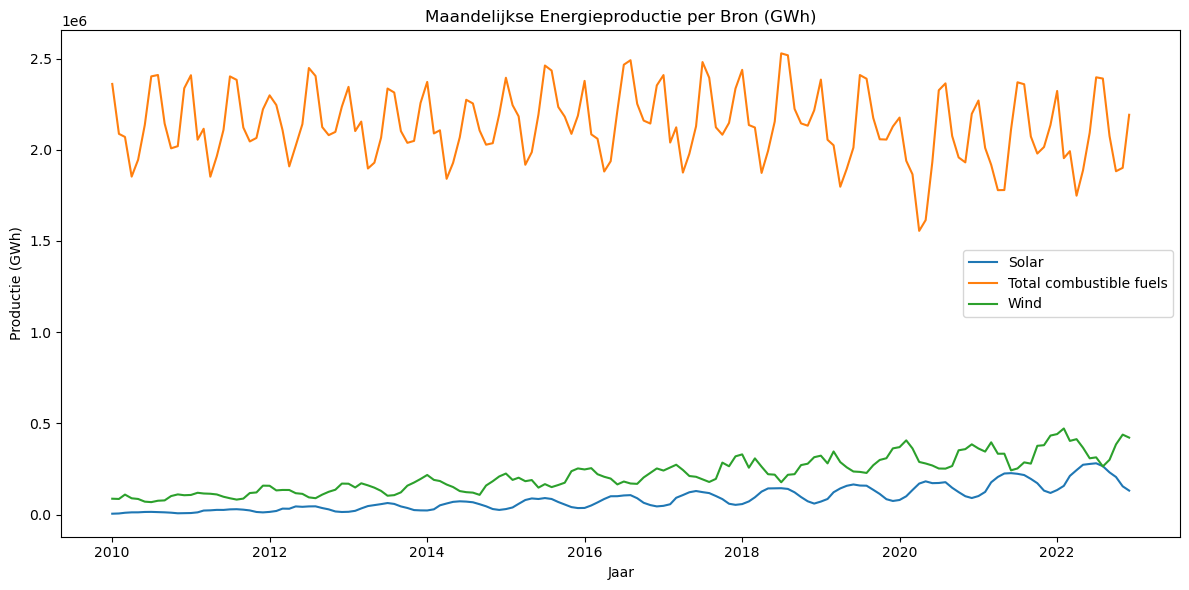

In [2]:
import matplotlib.pyplot as plt

main_sources = ['Solar', 'Wind', 'Total combustible fuels']
df = monthly_df[monthly_df['PRODUCT'].isin(main_sources)].copy()
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str))
pivot = df.pivot_table(index='DATE', columns='PRODUCT', values='VALUE', aggfunc='sum').dropna()

plt.figure(figsize=(12, 6))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], label=col)
plt.title("Maandelijkse Energieproductie per Bron (GWh)")
plt.xlabel("Jaar")
plt.ylabel("Productie (GWh)")
plt.legend()
plt.tight_layout()
plt.show()


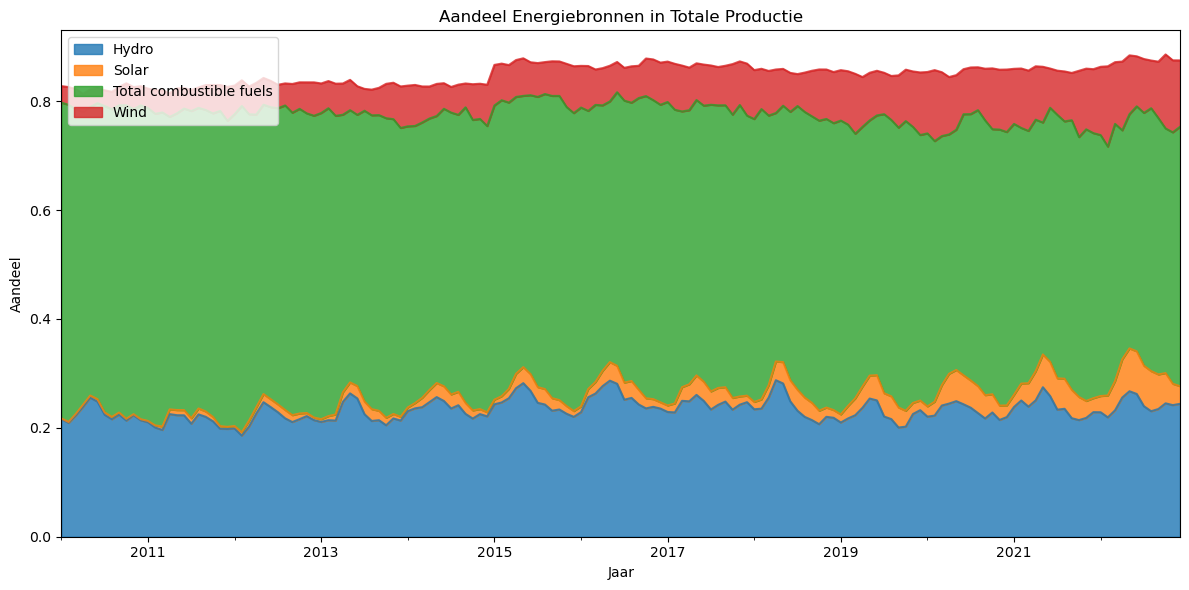

In [3]:
stack_sources = ['Solar', 'Wind', 'Hydro', 'Total combustible fuels']
df = monthly_df[monthly_df['PRODUCT'].isin(stack_sources)].copy()
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str))
pivot_share = df.pivot_table(index='DATE', columns='PRODUCT', values='share', aggfunc='mean').fillna(0)

pivot_share.plot.area(figsize=(12, 6), alpha=0.8)
plt.title("Aandeel Energiebronnen in Totale Productie")
plt.xlabel("Jaar")
plt.ylabel("Aandeel")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import plotly.express as px

# Kolomnaam instellen
col = 'Renewable energy share in the total final energy consumption (%)'

# Filter op rijen met geldige waarden
filtered = global_df[['Entity', 'Year', col]].dropna()

# Kies per land het laatste jaar met data
latest = filtered.loc[filtered.groupby('Entity')['Year'].idxmax()].copy()
latest.rename(columns={col: 'Renewable Share (%)'}, inplace=True)

# Plot met Plotly
fig = px.choropleth(
    latest,
    locations="Entity",
    locationmode="country names",
    color="Renewable Share (%)",
    color_continuous_scale="YlGn",
    title="Laatste Beschikbare Renewable Energy Share per Land",
    hover_name="Entity",
    hover_data={"Year": True}
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type="natural earth"
    ),
    coloraxis_colorbar=dict(
        title="% Renewable",
        ticks="outside"
    )
)

fig.show()




In [11]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1. Data inladen en filteren op 2019
df = global_df.copy()
year = 2019
df = df[df['Year'] == year].dropna(subset=[
    'gdp_per_capita',
    'Renewable energy share in the total final energy consumption (%)',
    'Access to electricity (% of population)',
    'Access to clean fuels for cooking',
    'Entity'
])

# 2. Kolommen hernoemen voor kortere labels
df = df.rename(columns={
    'gdp_per_capita': 'GDP per Capita',
    'Renewable energy share in the total final energy consumption (%)': 'Renewable Share (%)',
    'Access to electricity (% of population)': 'Electricity Access (%)',
    'Access to clean fuels for cooking': 'Clean Cooking (%)',
    'Entity': 'Country'
})

# 3. Log-transform van GDP om spreiding te verbeteren
df['Log GDP per Capita'] = np.log10(df['GDP per Capita'])

# 4. Bouw de Splom (scatter plot matrix)
fig = go.Figure(data=go.Splom(
    dimensions=[
        dict(label='Log GDP per Capita', values=df['Log GDP per Capita']),
        dict(label='Renewable Share (%)',   values=df['Renewable Share (%)']),
        dict(label='Electricity Access (%)',values=df['Electricity Access (%)']),
        dict(label='Clean Cooking (%)',     values=df['Clean Cooking (%)']),
    ],
    marker=dict(
        color=df['Clean Cooking (%)'],        # kleur op basis van clean cooking
        colorscale='Viridis',
        showscale=True,
        size=6,
        line=dict(width=0.5, color='DarkSlateGrey'),
        colorbar=dict(title='Clean Cooking (%)', ticks='outside')
    ),
    diagonal=dict(visible=False)  # geen histogrammen/KDE op diagonaal
))

# 5. Layout styling
fig.update_layout(
    title=f"Interactive Scatter Matrix – {year}",
    template='simple_white',
    width=800, height=800,
    dragmode='select',
    hovermode='closest',
    margin=dict(l=60, r=60, t=80, b=60),
    title_x=0.5
)

fig.show()


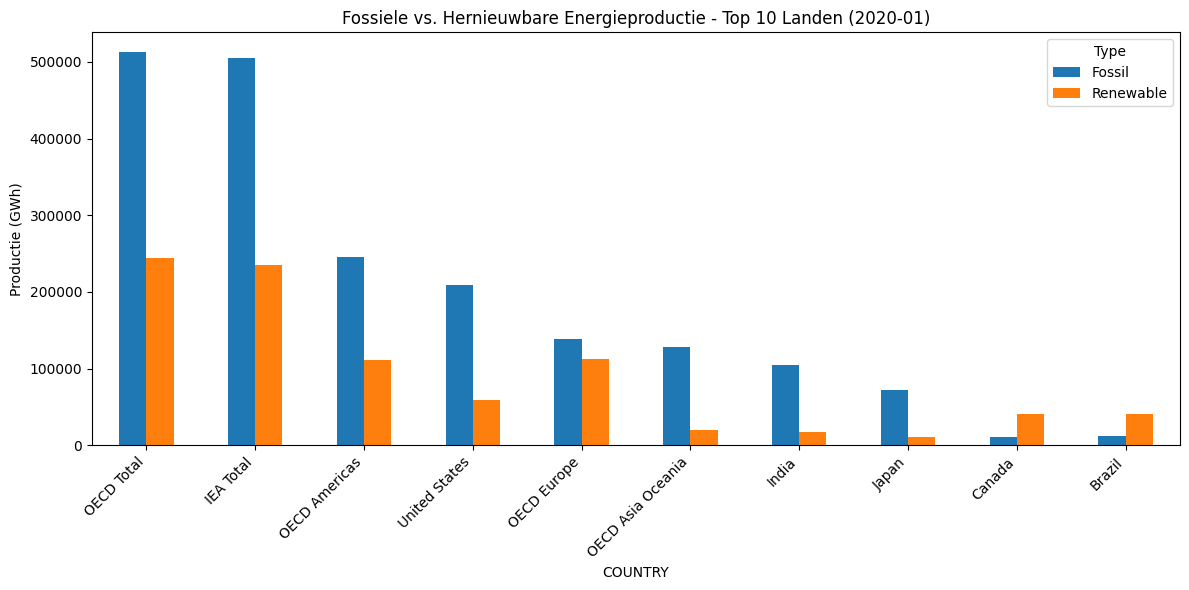

In [19]:
# Kies één maand/jaar
year = 2020
month = 1

df = monthly_df[(monthly_df['YEAR'] == year) & (monthly_df['MONTH'] == month)].copy()

# Alleen relevante bronnen
df = df[df['PRODUCT'].isin(['Total combustible fuels', 'Solar', 'Wind', 'Hydro'])]

# Categoriseer als 'Fossil' of 'Renewable'
def label_type(product):
    return 'Fossil' if product == 'Total combustible fuels' else 'Renewable'

df['Type'] = df['PRODUCT'].apply(label_type)

# Groepeer productie per land per type
agg = df.groupby(['COUNTRY', 'Type'])['VALUE'].sum().unstack().fillna(0)

# Top 10 landen met hoogste totale productie
top_countries = agg.sum(axis=1).sort_values(ascending=False).head(10)
top_agg = agg.loc[top_countries.index]

# Plot
top_agg.plot(kind='bar', figsize=(12, 6), stacked=False)
plt.title(f"Fossiele vs. Hernieuwbare Energieproductie - Top 10 Landen ({year}-{month:02})")
plt.ylabel("Productie (GWh)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


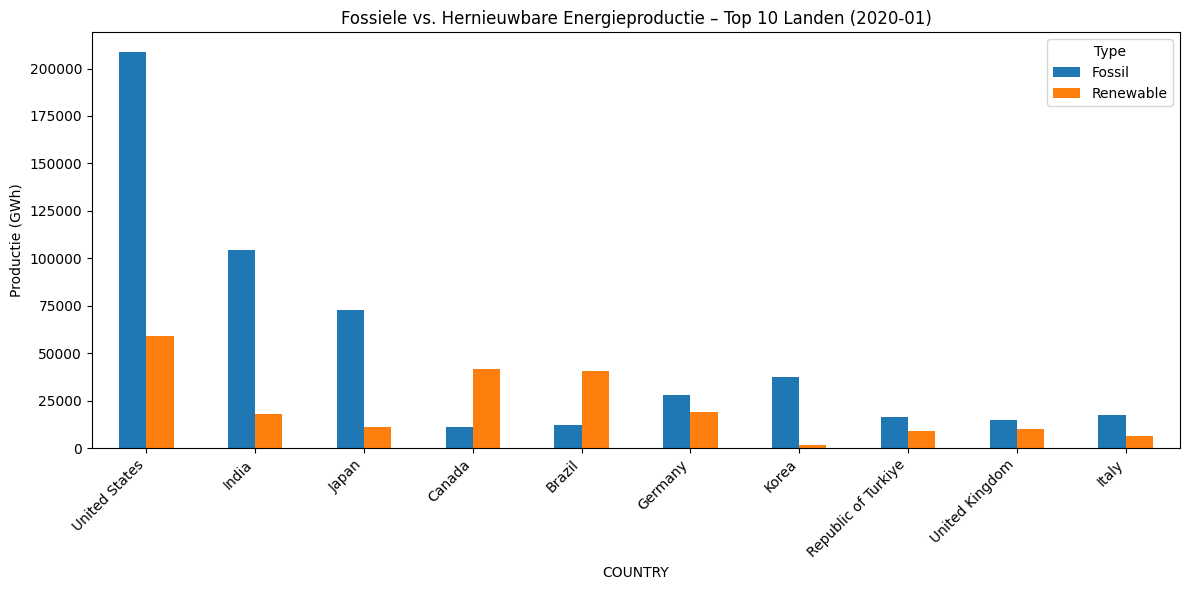

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataset inladen
monthly_df = pd.read_csv("data.csv")

# ❌ Lijst met niet-landen uitsluiten
exclude_entities = [
    'World', 'Africa', 'Asia', 'Europe', 'North America', 'South America',
    'European Union (27)', 'European Union (28)', 'OECD', 'Non-OECD',
    'Non-OECD Asia', 'Non-OECD Europe and Eurasia', 'Middle East', 'Eurasia',
    'Other Asia Pacific', 'Central & South America', 'IEA Net Zero by 2050 scenario',
    'IEA Total', 'IEA Europe', 'IEA Americas', 'IEA Asia Oceania',
    'OECD Total', 'OECD Americas', 'OECD Europe', 'OECD Asia Oceania'
]

# 📅 Filter op jaar + maand
year = 2020
month = 1
df = monthly_df[(monthly_df['YEAR'] == year) & (monthly_df['MONTH'] == month)].copy()

# 🔌 Alleen gewenste producten
df = df[df['PRODUCT'].isin(['Total combustible fuels', 'Solar', 'Wind', 'Hydro'])]

# 🧹 Verwijder niet-landen
df = df[~df['COUNTRY'].isin(exclude_entities)]

# 🌱 Label 'Fossil' of 'Renewable'
df['Type'] = df['PRODUCT'].apply(lambda x: 'Fossil' if x == 'Total combustible fuels' else 'Renewable')

# 📊 Groepeer per land/type
agg = df.groupby(['COUNTRY', 'Type'])['VALUE'].sum().unstack().fillna(0)

# 🔝 Top 10 landen met hoogste totale productie
top_countries = agg.sum(axis=1).sort_values(ascending=False).head(10)
top_agg = agg.loc[top_countries.index]

# 📈 Plot de bar chart
top_agg.plot(kind='bar', figsize=(12, 6), stacked=False)
plt.title(f"Fossiele vs. Hernieuwbare Energieproductie – Top 10 Landen ({year}-{month:02})")
plt.ylabel("Productie (GWh)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()







In [27]:
import pandas as pd
import plotly.express as px

# --- 1. Landen selecteren en data voorbereiden ---
selected = ['Germany', 'India', 'Nigeria', 'Afghanistan']
# Filter en hernoem kolommen
df = (global_df[global_df['Entity'].isin(selected)]
      .rename(columns={
          'Renewable energy share in the total final energy consumption (%)': 'Renewable Share (%)',
          'Access to electricity (% of population)': 'Electricity Access (%)'
      })
      .dropna(subset=['Year', 'Renewable Share (%)', 'Electricity Access (%)']))

# --- 2. Standaard kleurenpalet voor contrast ---
colors = px.colors.qualitative.Safe

# --- 3. Functie om lijnendiagram te plotten met directe labels ---
def plot_with_labels(df, y_col, title, y_label):
    fig = px.line(
        df,
        x='Year',
        y=y_col,
        color='Entity',
        markers=True,
        title=title,
        labels={'Year': 'Jaar', y_col: y_label, 'Entity': 'Land'},
        color_discrete_sequence=colors,
        width=800,
        height=500
    )
    # Layout-opties
    fig.update_layout(
        template='plotly_white',
        xaxis=dict(dtick=1, title='Jaar', showgrid=False),
        yaxis=dict(title=y_label, ticksuffix='%', showgrid=True, gridcolor='LightGray'),
        legend_title_text='Land',
        margin=dict(l=60, r=20, t=80, b=50)
    )
    # Directe labels: plaats landnamen bij laatste datapunt
    for i, country in enumerate(selected):
        d = df[df['Entity'] == country]
        if not d.empty:
            x_last = d['Year'].max()
            y_last = d.loc[d['Year'] == x_last, y_col].values[0]
            fig.add_annotation(
                x=x_last,
                y=y_last,
                text=country,
                xanchor='left',
                yanchor='middle',
                font=dict(color=colors[i], size=12),
                showarrow=False
            )
    fig.show()

# --- 4. Plot Renewable Share ---
plot_with_labels(
    df,
    y_col='Renewable Share (%)',
    title='Aandeel Hernieuwbare Energie per Jaar',
    y_label='Hernieuwbaar aandeel (%)'
)

# --- 5. Plot Electricity Access ---
plot_with_labels(
    df,
    y_col='Electricity Access (%)',
    title='Toegang tot Elektriciteit per Jaar',
    y_label='Elektriciteitstoegang (%)'
)



In [22]:
import pandas as pd
import plotly.graph_objects as go

# Load and categorize data
monthly_df = pd.read_csv("data.csv")
monthly_df['TIME'] = pd.to_datetime(monthly_df['TIME'], format='%B %Y')  # Correct format for "January 2010"

renewable_products = ['Hydro', 'Wind', 'Solar', 'Geothermal']
fossil_fuel_products = ['Total combustible fuels']

def assign_energy_type(product):
    if product in renewable_products: return 'Renewable'
    if product in fossil_fuel_products: return 'Fossil Fuel'
    return 'Other'

monthly_df['Energy_Type'] = monthly_df['PRODUCT'].apply(assign_energy_type)

# 2. Aggregate and calculate percentages
agg = (
    monthly_df
    .groupby(['TIME', 'Energy_Type'])['VALUE']
    .sum()
    .unstack(fill_value=0)
)
agg['Total'] = agg.sum(axis=1)
for col in ['Renewable', 'Fossil Fuel']:
    agg[col + '_pct'] = agg[col] / agg['Total'] * 100
agg = agg.reset_index().sort_values('TIME')

# 3. Create area chart with Graph Objects
fig = go.Figure()

# Fossil fuel area
fig.add_trace(go.Scatter(
    x=agg['TIME'], y=agg['Fossil Fuel_pct'],
    name='Fossil Fuel',
    mode='lines',
    line=dict(width=0.5, color='firebrick'),
    fill='tozeroy',
    fillcolor='rgba(178,34,34,0.6)',
    hovertemplate='Date: %{x|%Y-%m}<br>Fossil Fuel: %{y:.0f}%<extra></extra>'
))

# Renewable area, stacked above Fossil
fig.add_trace(go.Scatter(
    x=agg['TIME'], y=agg['Renewable_pct'] + agg['Fossil Fuel_pct'],
    name='Renewable',
    mode='lines',
    line=dict(width=0.5, color='forestgreen'),
    fill='tonexty',
    fillcolor='rgba(34,139,34,0.6)',
    customdata=agg['Renewable_pct'],  # Pass renewable percentage for hover
    hovertemplate='Date: %{x|%Y-%m}<br>Renewable: %{customdata:.0f}%<extra></extra>'
))

# 4. Add direct labels at the end
last = agg.iloc[-1]
annotations = [
    dict(x=last['TIME'], y=last['Fossil Fuel_pct']/2,
         text='Fossil Fuel', showarrow=False,
         font=dict(color='firebrick', size=12)),
    dict(x=last['TIME'], y=last['Fossil Fuel_pct'] + last['Renewable_pct']/2,
         text='Renewable', showarrow=False,
         font=dict(color='forestgreen', size=12)),
]

# 5. Layout & styling
fig.update_layout(
    template='simple_white',
    title=dict(text='Monthly Energy Production Breakdown by Type (Global %)', x=0.5),
    xaxis=dict(
        title='Date',
        tickformat='%Y',
        dtick='M12',
        showgrid=False
    ),
    yaxis=dict(
        title='Share (%)',
        range=[0,100],
        showgrid=True,
        gridcolor='LightGray',
        tickformat='.0f'
    ),
    margin=dict(l=60, r=20, t=80, b=50),
    showlegend=False,
    annotations=annotations
)

fig.show()

In [12]:
import pandas as pd
import plotly.express as px

# 1. Data laden en kolom hernoemen
df = pd.read_csv("global-data-on-sustainable-energy.csv")
df = df.rename(columns={
    "Renewable energy share in the total final energy consumption (%)": "Renewable_Share"
}).dropna(subset=["gdp_per_capita", "Renewable_Share", "Access to clean fuels for cooking"])

# 2. Bepaal de oplopende lijst met jaren
years_sorted = sorted(df["Year"].unique())

# 3. Maak de scatterplot met trendline en animatie
fig = px.scatter(
    df,
    x="gdp_per_capita",
    y="Renewable_Share",
    animation_frame="Year",
    category_orders={"Year": years_sorted},  # forceert de slider-orde
    hover_name="Entity",
    hover_data={
        "gdp_per_capita": ":,.0f",
        "Renewable_Share": ":.1f",
        "Access to clean fuels for cooking": ":.0f"
    },
    log_x=True,
    trendline="lowess",
    title="Renewable Energy Share vs. GDP per Capita (log scale)",
    labels={
        "gdp_per_capita": "GDP per Capita (USD)",
        "Renewable_Share": "Renewable Share (%)",
        "Access to clean fuels for cooking": "Clean Fuels (%)"
    },
    color="Access to clean fuels for cooking",
    color_continuous_scale="Viridis",
    width=900,
    height=600,
)

# 4. Marker- en lijnstijl
fig.update_traces(
    marker=dict(size=8, opacity=0.7, line=dict(width=1, color="DarkSlateGrey")),
    selector=dict(mode="markers")
)

# 5. Layout: clean white theme, gridlines en slider‐layout
fig.update_layout(
    template="plotly_white",
    xaxis=dict(
        type="log",
        tickformat=",",
        gridcolor="LightGray",
        title="GDP per Capita (log scale)"
    ),
    yaxis=dict(
        gridcolor="LightGray",
        title="Renewable Share (%)"
    ),
    coloraxis_colorbar=dict(
        title="Clean Fuels (%)",
        ticks="outside"
    ),
    sliders=[dict(
        currentvalue=dict(prefix="Year: "),
        pad=dict(t=50)
    )],
    title=dict(x=0.5, xanchor="center"),
    margin=dict(l=60, r=20, t=80, b=60)
)

fig.show()


In [24]:
import pandas as pd
import plotly.express as px

# Load the dataset
global_df = pd.read_csv("global-data-on-sustainable-energy.csv")

# Rename the column for convenience
global_df_renamed = global_df.rename(columns={'Renewable energy share in the total final energy consumption (%)': 'Renewable_Share'})

# Filter out non-country entities like 'World', 'European Union', etc.
df_countries = global_df_renamed[~global_df_renamed['Entity'].isin(['World', 'European Union', 'Africa', 'Asia', 'North America', 'South America', 'Europe', 'Oceania'])].copy()

# Select a subset of interesting countries for the small multiples
sample_countries = ['United States', 'China', 'India', 'Germany', 'Brazil', 'Nigeria', 'Japan', 'Australia', 'Norway', 'Saudi Arabia']
df_selected_countries = df_countries[df_countries['Entity'].isin(sample_countries)].dropna(subset=['Renewable_Share']).sort_values(by=['Entity', 'Year'])

# Corrected: Changed 'facet_wrap' to 'facet_col'
fig_facet_lines = px.line(
    df_selected_countries,
    x="Year",
    y="Renewable_Share",
    color="Entity", # Each country gets its own color (though it will be redundant with faceting)
    facet_col="Entity", # Create a subplot for each country
    facet_col_wrap=5, # Arrange in 5 columns
    title="Renewable Energy Share Trends for Selected Countries",
    labels={
        "Renewable_Share": "Renewable Share (%)",
        "Entity": "Country"
    },
    height=800 # Adjust height based on number of countries
)

fig_facet_lines.update_yaxes(matches=None) # Allow independent y-axes for better comparison if scales differ
fig_facet_lines.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1])) # Clean up facet titles

fig_facet_lines.show()

In [16]:
import pandas as pd
import plotly.express as px
import numpy as np

# 1. Data inladen en hernoemen
csv_path = "global-data-on-sustainable-energy.csv"
df = pd.read_csv(csv_path)
df.rename(
    columns={
        "Renewable energy share in the total final energy consumption (%)": "Renewable_Share"
    },
    inplace=True
)

# 2. Jaar-op-jaar groei berekenen per land
df.sort_values(["Entity", "Year"], inplace=True)
df['Growth'] = df.groupby("Entity")["Renewable_Share"].diff()

# 3. Categoriseer groei in Decline, Neutral, Increase
def categorize_growth(x):
    if pd.isna(x):
        return np.nan
    return 'Decline' if x < 0 else ('Neutral' if x == 0 else 'Increase')

growth_labels = ['Decline', 'Neutral', 'Increase']
df['Growth_Cat'] = df['Growth'].apply(categorize_growth)

# 4. Choropleth met earth tones kleuren en jaar-animatie
color_map = {
    'Decline': '#d62728',  # red for decline
    'Neutral': '#7f7f7f',  # grey for neutral
    'Increase': '#1f77b4'   # blue for increase
}  # contrasting palette for clarity

fig = px.choropleth(
    df,
    locations="Entity",
    locationmode="country names",
    color="Growth_Cat",
    category_orders={"Growth_Cat": growth_labels},
    color_discrete_map=color_map,
    hover_name="Entity",
    hover_data={"Renewable_Share": True, "Growth": ":.2f"},
    animation_frame="Year",
    title="Annual Growth of Renewable Energy Share per Country",
    width=1000,
    height=600
)

# 5. Kaartstijl met lichtblauwe oceaan en witte landen zonder data
fig.update_geos(
    showocean=True,
    oceancolor='lightblue',
    showlakes=True,
    lakecolor='lightblue',
    showcountries=True,
    countrycolor='LightGray',
    showframe=False,
    projection_type='equirectangular',
    landcolor='white'
)

# 6. Eenvoudige legendebalk bovenaan met earth tones
gap_top = 0.08
bar_height = 0.03  # smaller bar for more map space
t_colors = ['#d62728', '#7f7f7f', '#1f77b4']  # match color_map
t_labels = ['Decline (<0%)', 'Neutral (=0%)', 'Increase (>0%)']
shapes = []
annotations = []
for i, col in enumerate(t_colors):
    x0, x1 = i/3, (i+1)/3
    shapes.append({
        'type': 'rect', 'xref': 'paper', 'yref': 'paper',
        'x0': x0, 'x1': x1, 'y0': 1+gap_top, 'y1': 1+gap_top+bar_height,
        'fillcolor': col, 'line_width': 0
    })
    annotations.append({
        'xref': 'paper', 'yref': 'paper',
        'x': (x0+x1)/2, 'y': 1+gap_top-0.02,
        'text': t_labels[i], 'showarrow': False,
        'font': {'size': 12, 'family': 'Arial', 'color': '#333'},
        'align': 'center'
    })
fig.update_layout(
    shapes=shapes,
    annotations=annotations,
    margin={'t':100, 'b':50, 'l':20, 'r':20},  # reduce margins to enlarge map

    showlegend=False
)

# 7. Slider start op 2001
years = sorted(df['Year'].dropna().unique())
start_idx = years.index(2001) if 2001 in years else 0
fig.update_layout(
    sliders=[{
        'currentvalue': {'prefix': 'Year: '},
        'pad': {'t': 60},
        'active': start_idx
    }]
)

# 8. Toon de plot
fig.show()












In [15]:
import pandas as pd
import plotly.express as px

# 1) Data inladen
monthly = pd.read_csv("data.csv")

# 2) Definieer welke producten je wilt samenvatten
sources = ['Coal', 'Oil', 'Natural Gas', 'Hydro', 'Wind', 'Solar', 'Nuclear', 'Biomass']
monthly = monthly[monthly['PRODUCT'].isin(sources)]

# 3) Totalen per land/jaar en vind de grootste bron
agg = (
    monthly
    .groupby(['COUNTRY', 'YEAR', 'PRODUCT'])['VALUE']
    .sum()
    .reset_index()
)
dominant = (
    agg.sort_values(['COUNTRY', 'YEAR', 'VALUE'], ascending=[True, True, False])
       .groupby(['COUNTRY', 'YEAR'])
       .first()
       .reset_index()
       .rename(columns={'PRODUCT': 'Dominant_Source'})
)

# 4) Bepaal oplopende lijst met jaartallen
years_sorted = sorted(dominant['YEAR'].unique())

# 5) Choropleth met jaaranimatie (klein→groot)
color_map = {
    'Coal':        '#4C4C4C',
    'Oil':         '#A569BD',
    'Natural Gas': '#3498DB',
    'Hydro':       '#1ABC9C',
    'Wind':        '#2ECC71',
    'Solar':       '#F1C40F',
    'Nuclear':     '#E67E22',
    'Biomass':     '#95A5A6',
}

fig = px.choropleth(
    dominant,
    locations="COUNTRY",
    locationmode="country names",
    color="Dominant_Source",
    animation_frame="YEAR",
    category_orders={"YEAR": years_sorted},   # forceert oplopende volgorde
    color_discrete_map=color_map,
    title="Dominant Energy Source per Country Over Time",
    labels={"Dominant_Source": "Dominant Source"},
    width=1000,
    height=600
)

fig.update_layout(
    legend_title_text='Energy Source',
    margin=dict(t=100, b=50, l=50, r=50)
)

fig.show()
